# EIGSEP Image Fit

Aaron Parsons

In [ ]:
import numpy as np
import matplotlib.pylab as plt
from matplotlib.image import imread
import torch
from eigsep_terrain.marjum_dem import MarjumDEM as DEM
from eigsep_terrain.img import PRM_ORDER, HorizonImage, PositionSolver
import healpy
import pymc as pm
import pytensor
pytensor.config.cxx = ""    #type: ignore
import pytensor.tensor as pt
from pytensor.compile.ops import as_op
import os, sys, glob, tqdm
import multiprocessing as mp
import arviz, corner
from scipy.optimize import minimize

%matplotlib widget

In [ ]:
CACHE_FILE = 'marjum_dem.npz'
dem = DEM(cache_file=CACHE_FILE)

In [ ]:
dem['platform'] = np.array([1648, 2024, 1796])

meta = {}
meta['0817'] = {
    'best_prms': ( 1732.31,  2069.73,   1760.89,  1.4682,  3.6963, -0.0521,  9849.36),  #[LOSS= 0.0378]
    'ant_px': (2*1366, 2*1221),
}
meta['0833'] = {
    'best_prms': ( 1611.38,  1847.62,   1659.85,  1.2062,  1.2401, -0.0250,  5072.38),  #[LOSS= 0.0254]
    'ant_px': (1606, 2700),
}

#meta['0834'] = {
#    'best_prms': ( 1642.45,  1887.80,   1678.94,  1.1787,  1.2417, -0.0310,  2933.66),  #[LOSS= 0.0685]
#    'ant_px': (1622, 2251),
#}

meta['0860'] = {
    #'best_prms': ( 1539.90,  1989.78,   1765.54,  1.5423,  0.6162,  0.1541,  2328.29),  #[LOSS= 0.0206]
    #'best_prms': ( 1538.80,  2001.28,   1765.46,  1.5411,  0.6109,  0.1589,  2328.29),  #[LOSS= 0.0166]
    'best_prms': ( 1540.51,  1998.55,   1766.85,  1.5421,  0.6131,  0.1584,  2328.30),  #[LOSS= 0.0151]
    'ant_px': (2924, 1945),
}

for k in meta.keys():
    dem[k] = np.asarray(meta[k]['best_prms'][:3], dtype=np.float32)
    
files = sorted(glob.glob('//Users/komalkaur/Desktop/eigsep_stuff/hrzn_mapping/imgs/*.jpg'))
#files = sorted(glob.glob('/home/aparsons/Downloads/IMG_08*.jpg'))[-1:]
print(files)
imgs = [HorizonImage(f, meta) for f in files]
imgs = [img for img in imgs if img.key in meta]


['//Users/komalkaur/Desktop/eigsep_stuff/hrzn_mapping/imgs/IMG_0817.jpg', '//Users/komalkaur/Desktop/eigsep_stuff/hrzn_mapping/imgs/IMG_0833.jpg', '//Users/komalkaur/Desktop/eigsep_stuff/hrzn_mapping/imgs/IMG_0860.jpg']


In [ ]:
dem.interp_alt(imgs[-1].prms['e'], imgs[-1].prms['n'])


1758

In [ ]:
# overlay ray tracing

if False:
    fig, axes = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(7, 4 * 3))
    r_imgs = {}
    sl = slice(None, None, 4)
    img_pkg = imgs[-1]
    axes[0].imshow(img_pkg.img[sl,sl], origin='lower')
    axes[2].imshow(img_pkg.img[sl,sl], origin='lower')
    r_imgs[img_pkg.key] = img_pkg.ray_distance(dem, img_pkg.get_rays()[...,sl,sl])
    axes[1].imshow(r_imgs[img_pkg.key], origin='lower', cmap='gist_ncar')
    axes[0].imshow(r_imgs[img_pkg.key], origin='lower', cmap='gist_ncar', alpha=0.4)
    plt.tight_layout()


In [ ]:
# i = imgs[0]
# npz = np.load(i.npzfile)
# plt.figure()
# plt.imshow(npz['sky'])


In [ ]:
if False:
    fig, axes = plt.subplots(ncols=len(imgs), figsize=(7 * len(imgs), 6))
    if len(imgs) == 1:
        axes = [axes]
    r_imgs = {}
    sl = slice(None, None, 8)
    for cnt, img_pkg in enumerate(imgs):
        axes[cnt].imshow(img_pkg.img[sl,sl], origin='lower')
        r_imgs[img_pkg.key] = img_pkg.ray_distance(dem, img_pkg.get_rays()[...,sl,sl])
        axes[cnt].imshow(r_imgs[img_pkg.key], origin='lower', cmap='gist_ncar', alpha=0.4)
    plt.tight_layout()

In [ ]:
if False:
    fig, axes = plt.subplots(ncols=len(imgs), figsize=(7 * len(imgs), 6))
    if len(imgs) == 1:
        axes = [axes]
    for cnt, img_pkg in enumerate(imgs):
        axes[cnt].imshow(img_pkg.img, origin='lower')
        axes[cnt].imshow(img_pkg.sky_mask, origin='lower', alpha=0.3)
        axes[cnt].imshow(img_pkg.horizon_mask, origin='lower', alpha=0.3)
        mask = img_pkg.mask_near_horizon(50)
        x, y = img_pkg.choose_pixels(mask=mask, N=16000//3)
        is_sky = img_pkg.sky_mask[x, y]
        axes[cnt].plot(y[is_sky], x[is_sky], 'b,')
        axes[cnt].plot(y[~is_sky], x[~is_sky], 'r,')
        axes[cnt].plot(*img_pkg.meta['ant_px'], 'k+')

In [ ]:
#nside = 512
##e0, n0, u0 = (1754, 2100, 1747)
#e0, n0, u0 = start_point = np.array((1767, 2095, 1759), dtype=float)
#rays = et.ray.healpix_rays(nside)
##e0, n0, u0 = start_point = np.array(dem['1P'], dtype=float)
##e0, n0, u0 = (0, 0, 1759)

In [ ]:
#healpy.mollview(h.map)
#healpy.mollview(np.log10(ray_trace(start_point)), cmap='plasma')
#healpy.mollview(np.log10(r), cmap='plasma')
#healpy.mollview(np.log10(r2), cmap='plasma')
#healpy.mollview(T[-1], cmap='plasma')
#healpy.mollview((T_sky_full[:, 180]), cmap='plasma')

In [ ]:
# for one image

I = imgs[2]
I.reset_pixel_choice()
I.horizon_ray_loss(dem, cnt=16000);
ant_ray = I.get_rays(np.array(I.meta['ant_px'][::-1]))
prms = dict(zip(PRM_ORDER, I.get_prms()))
r_ant = dem['platform'] - np.array([prms['e'], prms['n'], prms['u']])

delta_theta = np.arccos(np.dot(ant_ray, r_ant) / (np.linalg.norm(ant_ray) * np.linalg.norm(r_ant))) # rad
BOX_SIZE = 0.3 # m
sigma_theta = BOX_SIZE / np.linalg.norm(r_ant)

logL = -delta_theta / (2 * sigma_theta**2) # :0
logL
                        

'best_prms': ( 1540.51,  1998.55,   1766.85,  1.5421,  0.6131,  0.1584,  2328.30),  #[LOSS= 0.0544]


-8694.42794836528

In [ ]:
sigmas = (30.0, 30.0, 30.0, np.deg2rad(5.0), np.deg2rad(5.0), np.deg2rad(5.0), 0.1)
BOX_SIZE = 0.3 # m
ANT_POS_ERR = 20 #m
ant_pos_prior = np.array([1646, 2022, 1782])
fit_imgs = []
static_imgs = imgs
n_rays = 1600

pos_slvr = PositionSolver(ant_pos_prior, fit_imgs, static_imgs, n_rays, dem, ant_pos_err=20, box_size=0.3)

# def build_model():
#     """
#     eps: per-pixel error rate for mismatches (small)
#     """

#     with pm.Model() as model:
#         pos_slvr.set_mcmc_sigmas()
#         prms = pos_slvr.get_mcmc_prms()
               
#         theta = pt.stack(prms)
#         logp = pos_slvr.total_loss(theta)
            
#         pm.Potential("lik", logp)

#     return model

In [ ]:
# if True:
#     with build_model() as model:
#         # step = pm.DEMetropolisZ(
#         step = pm.Metropolis(
#             S=np.array(pos_slvr.sigmas),
#             scaling=.01,      # much bigger than 1e-3, TODO: may need to tune this
#             tune='scaling',   # let it adapt scale
#             tune_interval=50, # adapt more often than default 100
#         )
        
#         trace = pm.sample(
#             draws=5000,
#             tune=3000,
#             chains=4,   #TODO: go back to 4 once this works
#             step=step,
#             cores=4,
#             random_seed=42,
#             progressbar=True,
#         )
#     arviz.to_netcdf(trace, f"{I.key}_trace.nc");
#     print(f"Accepted step fraction = {float(trace.sample_stats.accepted.mean()): 4.3f}")
#     # rejecting most steps = steps too big
#     # accepting most steps = steps too small

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [ant_e]
>Metropolis: [ant_n]
>Metropolis: [ant_u]


Output()

/Users/komalkaur/miniconda3/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:321: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/Users/komalkaur/miniconda3/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:321: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/Users/komalkaur/miniconda3/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:321: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


/Users/komalkaur/miniconda3/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:321: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 3_000 tune and 5_000 draw iterations (12_000 + 20_000 draws total) took 541 seconds.


Accepted step fraction =  0.327


In [ ]:
# trace_files = sorted(glob.glob("*.nc"))
# print(trace_files)
# traces = {f.split('_')[0]: arviz.from_netcdf(f) for f in trace_files}


['0860_trace.nc']


In [ ]:
# # Load the trace file
# trace = arviz.from_netcdf("0860_trace.nc")

# # Check if it actually has samples (not constants)
# print("Checking if samples vary:")
# for var in trace.posterior.data_vars:
#     data = trace.posterior[var].values
#     print(f"{var}: shape={data.shape}, std={data.std():.6e}, range={data.max()-data.min():.6e}")

Checking if samples vary:
ant_e: shape=(4, 5000, 3), std=1.044342e-01, range=8.476099e-01
ant_n: shape=(4, 5000, 3), std=1.034218e-01, range=9.077005e-01
ant_u: shape=(4, 5000, 3), std=1.043729e-01, range=8.024831e-01


In [ ]:
# # Check if 0860 parameters actually vary
# posterior = traces['0860'].posterior

# for var in posterior.data_vars:
#     data = posterior[var].values.flatten()
#     print(f"{var}: min={data.min():.4f}, max={data.max():.4f}, "
#           f"unique={len(np.unique(data))}, std={data.std():.6f}")

ant_e: min=1803.4889, max=1804.3365, unique=19088, std=0.104434
ant_n: min=1803.4425, max=1804.3502, unique=18575, std=0.103422
ant_u: min=1803.5039, max=1804.3064, unique=21188, std=0.104373


In [ ]:
# traces

{'0860': Inference data with groups:
 	> posterior
 	> sample_stats}

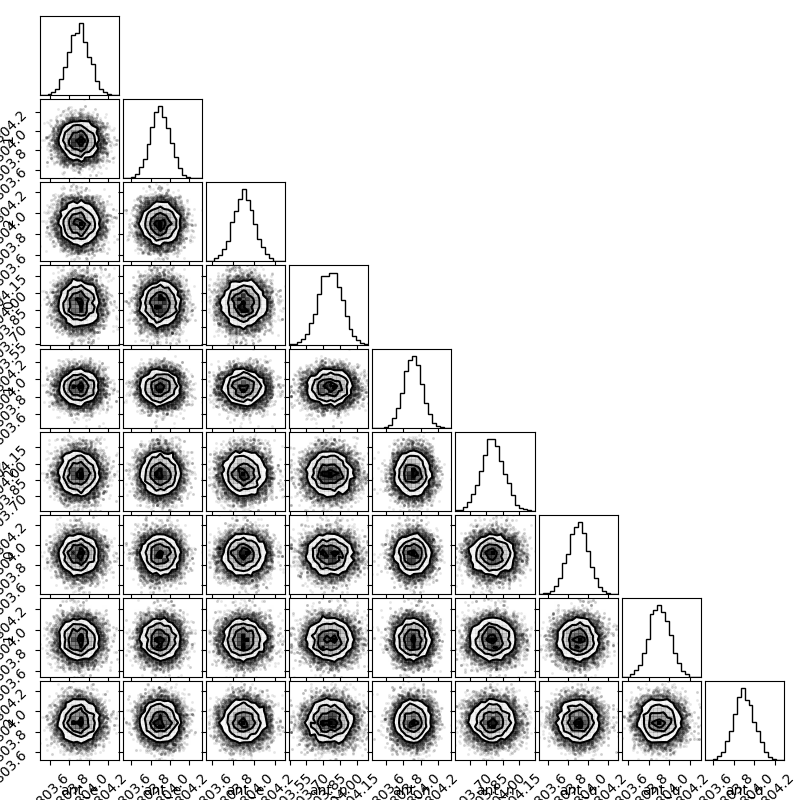

In [ ]:
# fig = plt.figure(figsize=(8, 8))
# # type(traces['0860'])
# corner.corner(traces['0860'], fig=fig);

In [ ]:
def plot_img(ax, data, res=dem.res, xlabel=True, ylabel=True,
             colorbar=False, cmap='terrain', erng=None, nrng=None, **kw):
    '''Plot maps with standard format.'''
    if nrng is None:
        nrng = (0, data.shape[0] * res)
    if erng is None:
        erng = (0, data.shape[1] * res)
    extent = erng + nrng
    im = ax.imshow(data, extent=extent, cmap=cmap, origin='lower', interpolation='nearest', **kw)
    if colorbar:
        plt.colorbar(im)
    if xlabel:
        ax.set_xlabel('East [m]')
    if ylabel:
        ax.set_ylabel('North [m]')

In [ ]:
# #e,n,u = dem.latlon_to_enu(39.247907, -113.402715)
# #u = dem.interp_alt(e, n)
# #print(e, n, u)
# fig, ax = plt.subplots()
# e0, n0, u0 = dem['platform']
# rng = 750
# plot_img(ax, dem.data, dem.res)
# plt.plot([e0], [n0], 's', color='k')
# for img in imgs[-1:]:
#     e, n, u = img.prms['e'], img.prms['n'], img.prms['u']
#     plt.plot([e], [n], '+', color='blue')
#     ant_ray = img.get_rays(pixels=np.array(img.meta['ant_px'][::-1]))
#     plt.plot([e, e + ant_ray[0] * 220], [n, n + ant_ray[1] * 220], ':', color='k')
#     trace = traces[img.key]
#     # try:
#     #     plt.plot(np.asarray(trace.posterior[f'{img.key}_e']).flatten(), np.asarray(trace.posterior[f'{img.key}_n']).flatten(), '.');
#     # except(KeyError):
#     plt.plot(np.asarray(trace.posterior['e']).flatten(), np.asarray(trace.posterior['n']).flatten(), '.');


In [ ]:
# summary = arviz.summary(posterior)
# summary


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ant_e[0],1803.901,0.106,1803.707,1804.099,0.002,0.001,3774.0,3955.0,1.0
ant_e[1],1803.902,0.103,1803.711,1804.099,0.002,0.001,4157.0,4183.0,1.0
ant_e[2],1803.900,0.104,1803.710,1804.106,0.002,0.001,4415.0,4691.0,1.0
ant_n[0],1803.907,0.104,1803.712,1804.099,0.002,0.001,3550.0,3985.0,1.0
ant_n[1],1803.905,0.103,1803.709,1804.099,0.002,0.001,3949.0,4044.0,1.0
ant_n[2],1803.908,0.103,1803.718,1804.105,0.002,0.001,4279.0,4500.0,1.0
ant_u[0],1803.901,0.104,1803.715,1804.104,0.002,0.001,4197.0,4534.0,1.0
ant_u[1],1803.903,0.104,1803.716,1804.103,0.002,0.001,3671.0,4209.0,1.0
ant_u[2],1803.903,0.105,1803.715,1804.106,0.002,0.001,4019.0,4489.0,1.0


In [ ]:
# avgs = summary['mean']
# mean_ant_e = np.mean([avgs['ant_e[0]'], avgs['ant_e[1]'], avgs['ant_e[2]']])
# mean_ant_n = np.mean([avgs['ant_n[0]'], avgs['ant_n[1]'], avgs['ant_n[2]']])
# mean_ant_u = np.mean([avgs['ant_u[0]'], avgs['ant_u[1]'], avgs['ant_u[2]']])

# print(f'antenna enu from mcmc: e: {np.round(mean_ant_e)}, n:{np.round(mean_ant_n)}, u:{np.round(mean_ant_u)}')


antenna enu from mcmc: e: 1804.0, n:1804.0, u:1804.0


In [ ]:
# avgs = summary['r_hat']
# mean_r_hat_e = np.mean([avgs['ant_e[0]'], avgs['ant_e[1]'], avgs['ant_e[2]']])
# mean_r_hat_n = np.mean([avgs['ant_n[0]'], avgs['ant_n[1]'], avgs['ant_n[2]']])
# mean_r_hat_u = np.mean([avgs['ant_u[0]'], avgs['ant_u[1]'], avgs['ant_u[2]']])

# print(f'antenna r_hat from mcmc: e: {mean_r_hat_e}, n:{mean_r_hat_n}, u:{mean_r_hat_u}')


antenna r_hat from mcmc: e: 1.0, n:1.0, u:1.0


In [ ]:
# avgs = summary['ess_bulk']
# mean_ess_bulk_e = np.mean([avgs['ant_e[0]'], avgs['ant_e[1]'], avgs['ant_e[2]']])
# mean_ess_bulk_n = np.mean([avgs['ant_n[0]'], avgs['ant_n[1]'], avgs['ant_n[2]']])
# mean_ess_bulk_u = np.mean([avgs['ant_u[0]'], avgs['ant_u[1]'], avgs['ant_u[2]']])

# print(f'antenna ess_bulk from mcmc: e: {mean_ess_bulk_e}, n:{mean_ess_bulk_n}, u:{mean_ess_bulk_u}')


antenna ess_bulk from mcmc: e: 4115.333333333333, n:3926.0, u:3962.3333333333335


array([[<Axes: title={'center': 'ant_e'}>,
        <Axes: title={'center': 'ant_e'}>],
       [<Axes: title={'center': 'ant_n'}>,
        <Axes: title={'center': 'ant_n'}>],
       [<Axes: title={'center': 'ant_u'}>,
        <Axes: title={'center': 'ant_u'}>]], dtype=object)

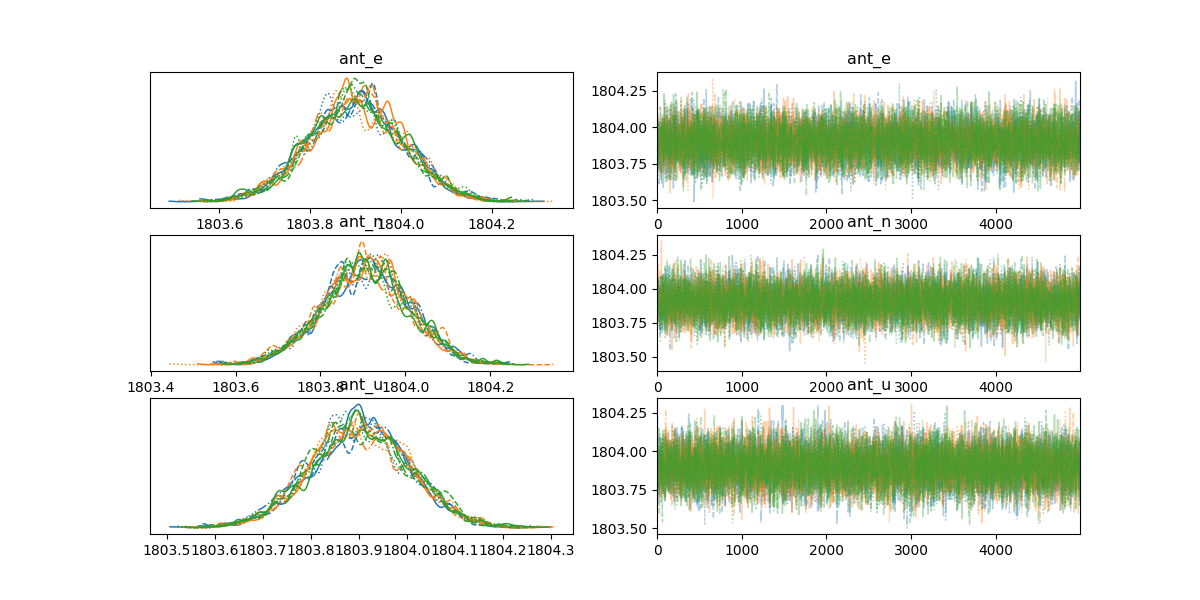

In [ ]:
# arviz.plot_trace(posterior)


array([[<Axes: title={'center': 'ant_e\n0, 0'}>,
        <Axes: title={'center': 'ant_e\n0, 1'}>,
        <Axes: title={'center': 'ant_e\n0, 2'}>,
        <Axes: title={'center': 'ant_e\n1, 0'}>],
       [<Axes: title={'center': 'ant_e\n1, 1'}>,
        <Axes: title={'center': 'ant_e\n1, 2'}>,
        <Axes: title={'center': 'ant_e\n2, 0'}>,
        <Axes: title={'center': 'ant_e\n2, 1'}>],
       [<Axes: title={'center': 'ant_e\n2, 2'}>,
        <Axes: title={'center': 'ant_e\n3, 0'}>,
        <Axes: title={'center': 'ant_e\n3, 1'}>,
        <Axes: title={'center': 'ant_e\n3, 2'}>],
       [<Axes: title={'center': 'ant_n\n0, 0'}>,
        <Axes: title={'center': 'ant_n\n0, 1'}>,
        <Axes: title={'center': 'ant_n\n0, 2'}>,
        <Axes: title={'center': 'ant_n\n1, 0'}>],
       [<Axes: title={'center': 'ant_n\n1, 1'}>,
        <Axes: title={'center': 'ant_n\n1, 2'}>,
        <Axes: title={'center': 'ant_n\n2, 0'}>,
        <Axes: title={'center': 'ant_n\n2, 1'}>],
       [<Axes: 

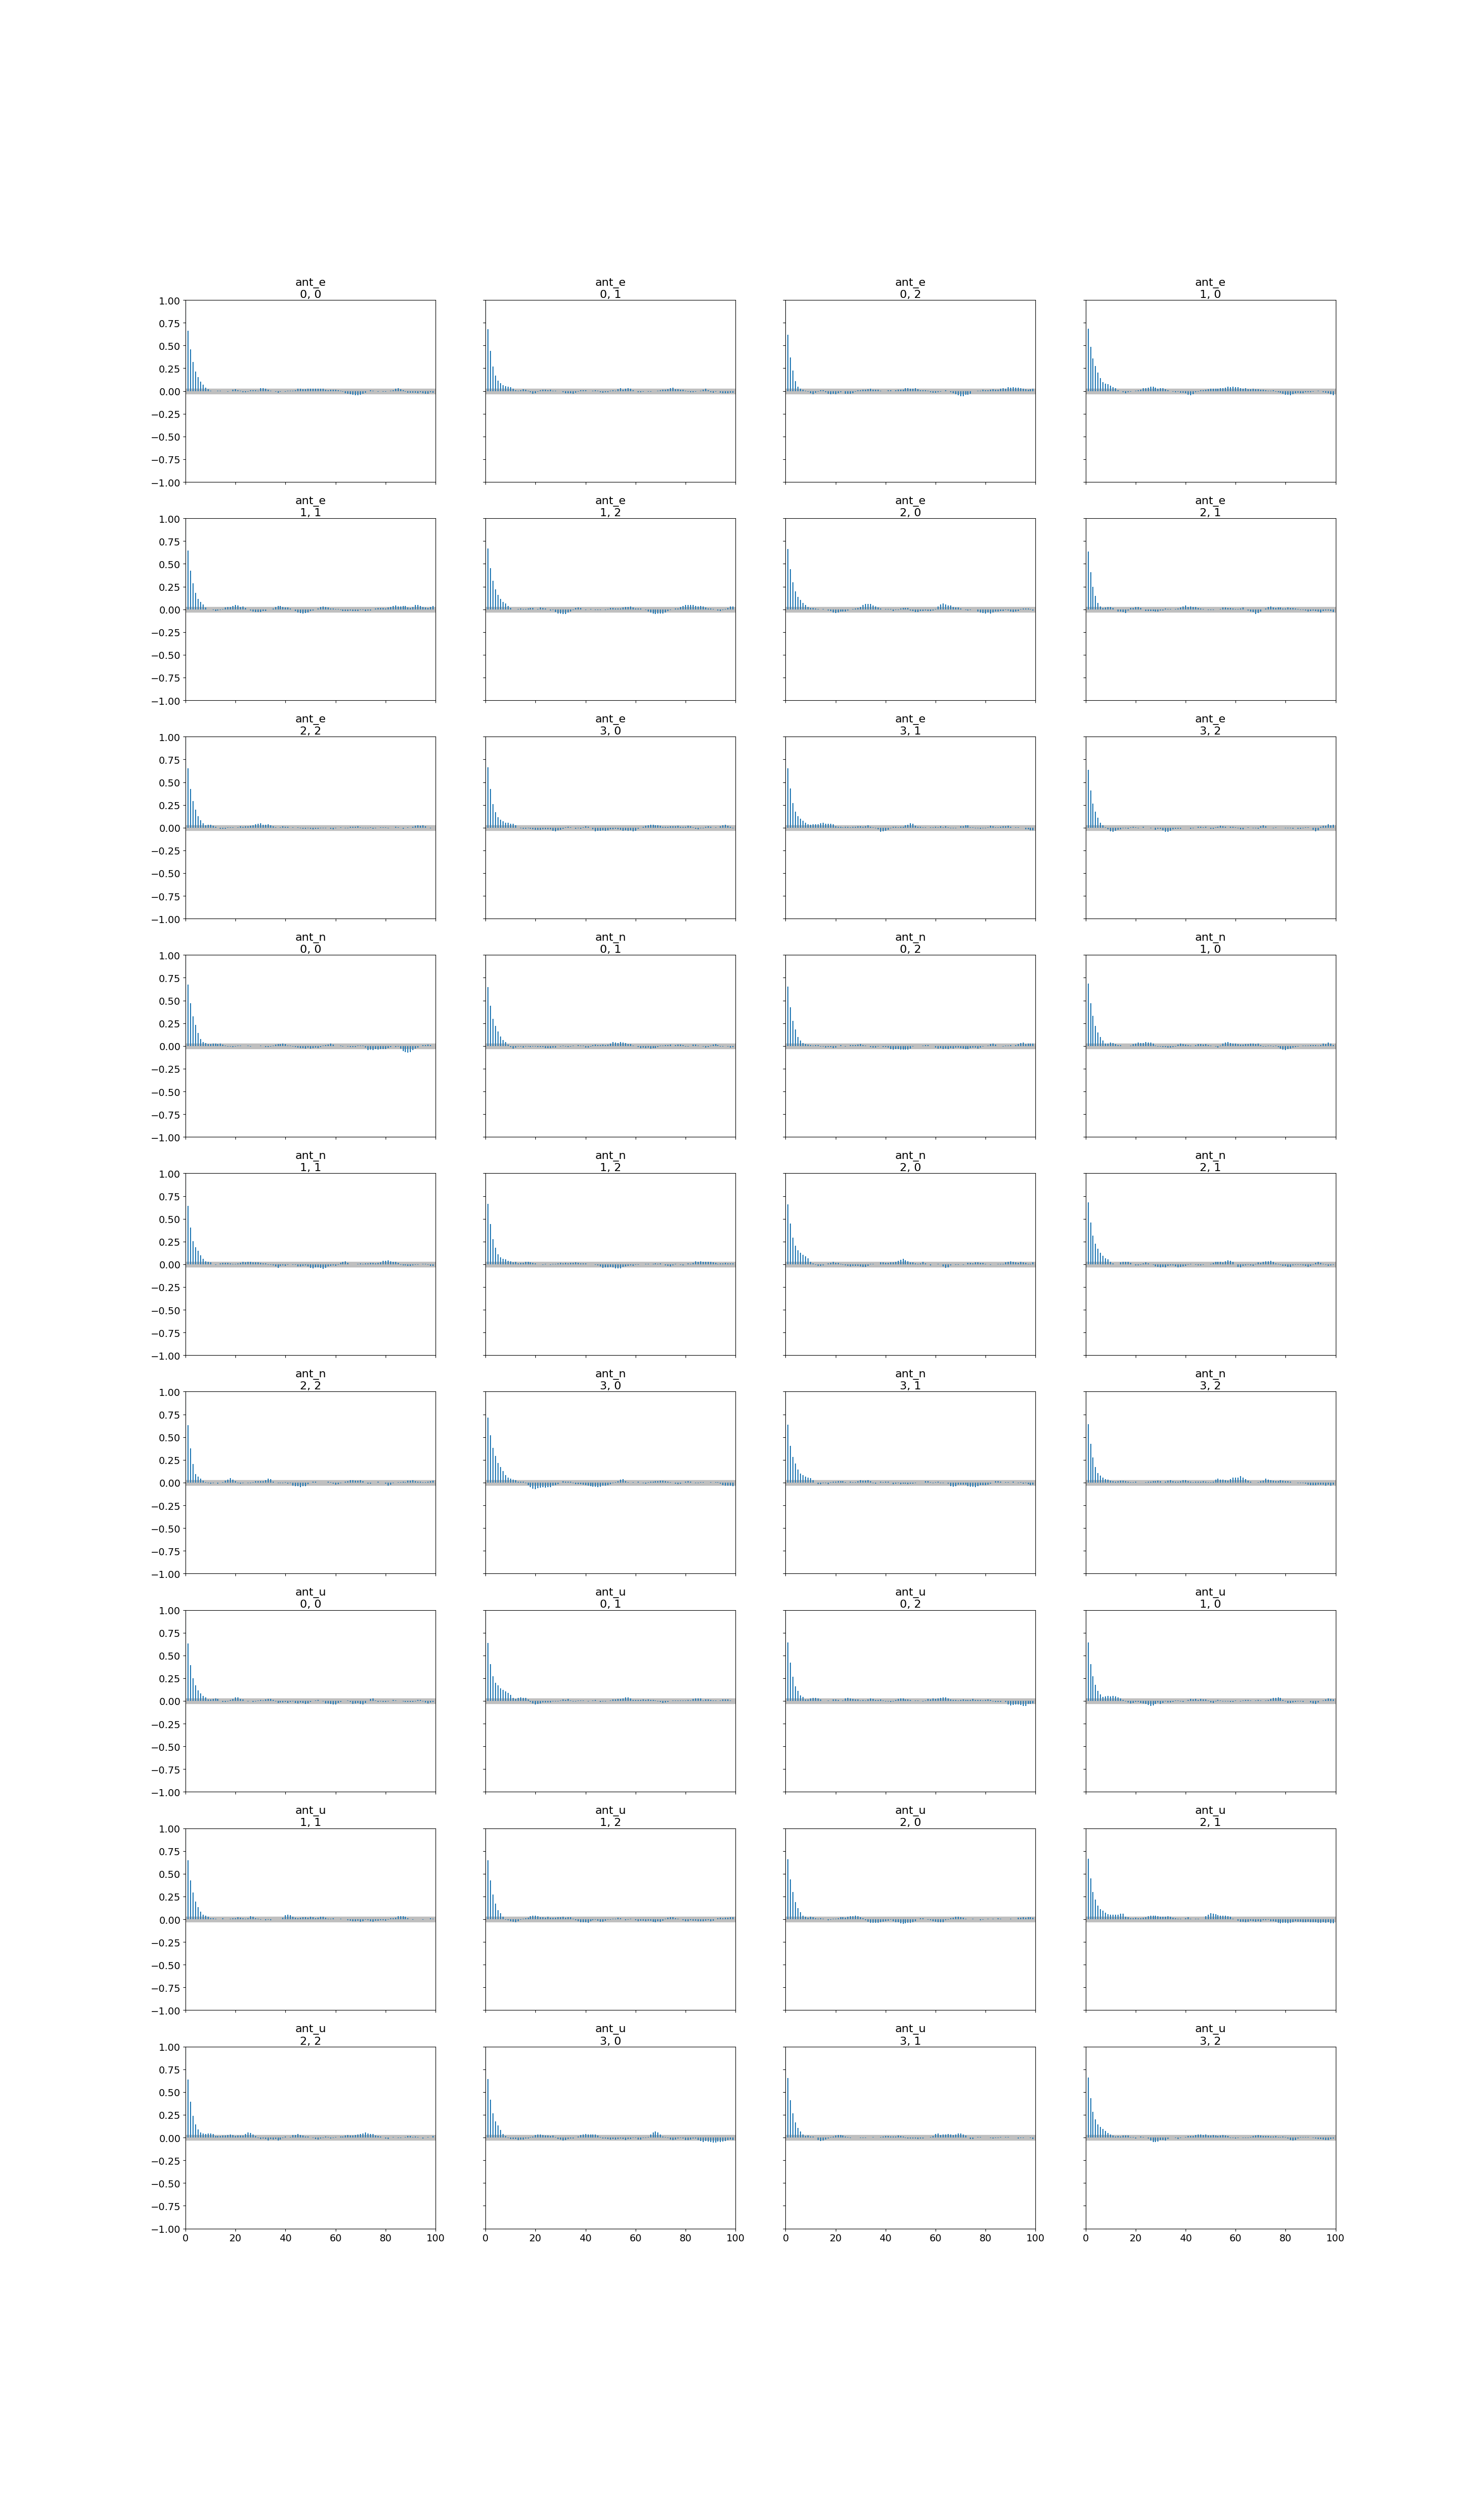

In [ ]:
# arviz.plot_autocorr(posterior)


In [ ]:
# # Test with prior
# theta_prior = ant_pos_prior
# pos_slvr.set_mcmc_prms(theta_prior)
# logp_prior = pos_slvr.total_loss(theta_prior)
# print(f"Log prob at prior [1646, 2022, 1782]: {logp_prior}")

# # Test with MCMC result
# theta_mcmc = np.array([mean_ant_e, mean_ant_n, mean_ant_u])
# pos_slvr.set_mcmc_prms(theta_mcmc)
# logp_mcmc = pos_slvr.total_loss(theta_mcmc)
# print(f"Log prob at MCMC [1804, 1804, 1804]: {logp_mcmc}")

# print(f"\nMCMC result is better: {logp_mcmc > logp_prior}")
# print(f"Difference: {logp_mcmc - logp_prior}")

Log prob at prior [1646, 2022, 1782]: -8989.124909286027
Log prob at MCMC [1804, 1804, 1804]: -1491756.9136794908

MCMC result is better: False
Difference: -1482767.7887702049


In [ ]:
# # Test a few random points
# import random
# for _ in range(5):
#     test_pos = ant_pos_prior + np.random.randn(3) * 50  # Random points near prior
#     pos_slvr.set_mcmc_prms(test_pos)
#     logp_test = pos_slvr.total_loss(test_pos)
#     print(f"Position {test_pos}: logp = {logp_test}")

Position [1510.9152354  2039.69225017 1772.6237779 ]: logp = -338202.81061845104
Position [1651.70903493 2062.03893505 1787.05646505]: logp = -69273.97647763115
Position [1663.97919728 2027.27314259 1749.38663226]: logp = -74258.65693005141
Position [1708.17077006 2058.81718423 1861.72992155]: logp = -257525.61630278092
Position [1649.36097256 2091.44799841 1867.94048696]: logp = -279933.0437467393


In [ ]:
# MAP
def neg_log_prob(theta):
    return -pos_slvr.total_loss(theta)

result = minimize(
    neg_log_prob,
    x0=ant_pos_prior,
    method='Nelder-Mead',  # or 'Powell', doesn't need gradients
    options={'disp': True, 'maxiter': 1000}
)

print(f"Optimized position (MAP result): {result.x}")
print(f"Log probability: {-result.fun}")

Optimization terminated successfully.
         Current function value: 2897.744428
         Iterations: 108
         Function evaluations: 212
Optimized position (MAP result): [1652.68004551 2024.58714886 1781.59928882]
Log probability: -2897.7444281024746


In [ ]:
# 1. The best estimate (MAP from scipy)
map_estimate = result.x
print(f"MAP Estimate:")
print(f"  ant_e: {map_estimate[0]:.2f}")
print(f"  ant_n: {map_estimate[1]:.2f}")
print(f"  ant_u: {map_estimate[2]:.2f}")


MAP Estimate:
  ant_e: 1652.68
  ant_n: 2024.59
  ant_u: 1781.60


In [ ]:
print(f"Optimization success: {result.success}")
print(f"Optimization message: {result.message}")
print(f"Number of iterations: {result.nit}")
print(f"Number of function evaluations: {result.nfev}")

Optimization success: True
Optimization message: Optimization terminated successfully.
Number of iterations: 108
Number of function evaluations: 212


In [ ]:
# Try with more iterations and tighter tolerance
# Or use L-BFGS-B with bounds
result = minimize(
    neg_log_prob,
    x0=ant_pos_prior,
    method='L-BFGS-B',
    options={'disp': True, 'maxiter': 10000, 'ftol': 1e-10}
)

print(f"\nOptimization converged: {result.success}")
print(f"Final gradient norm: {np.linalg.norm(approx_fprime(result.x, neg_log_prob, 1e-6))}")
print(f"Optimized position: {result.x}")
print(f"Log probability: {-result.fun}")

# Now try Hessian again
if result.success:
    hessian = compute_hessian(neg_log_prob, result.x, eps=1e-5)
    
    try:
        post_cov = np.linalg.inv(hessian)
        post_std = np.sqrt(np.diag(post_cov))
        
        print(f"\nProper 95% CI:")
        print(f"  ant_e: {result.x[0]:.2f} ± {1.96*post_std[0]:.2f}")
        print(f"  ant_n: {result.x[1]:.2f} ± {1.96*post_std[1]:.2f}")
        print(f"  ant_u: {result.x[2]:.2f} ± {1.96*post_std[2]:.2f}")
    except:
        print("Hessian still singular")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.98912D+03    |proj g|=  1.29142D+03

At iterate    1    f=  8.41107D+03    |proj g|=  8.30160D+02

At iterate    2    f=  4.94064D+03    |proj g|=  7.94130D+02


Optimization converged: True
Final gradient norm: 1277.863388376423
Optimized position: [1652.66817421 2024.53654643 1781.56436967]
Log probability: -2898.783352764369

Proper 95% CI:
  ant_e: 1652.67 ± 0.00
  ant_n: 2024.54 ± nan
  ant_u: 1781.56 ± 0.00
At iterate    3    f=  4.47684D+03    |proj g|=  1.43302D+03

At iterate    4    f=  3.44323D+03    |proj g|=  1.10058D+03

At iterate    5    f=  3.31556D+03    |proj g|=  6.12996D+02

At iterate    6    f=  3.22090D+03    |proj g|=  8.15422D+02

At iterate    7    f=  3.20625D+03    |proj g|=  1.31821D+03

At iterate    8    f=  3.02419D+03    |proj g|=  8.42196D+02

At iterate    9   

 This problem is unconstrained.
/var/folders/q0/wmkw3ygx6g39dcd_tv9267z40000gn/T/ipykernel_6699/9915397.py:21: RuntimeWarning: invalid value encountered in sqrt
  post_std = np.sqrt(np.diag(post_cov))


problem is unconstrained: issue with ant_loss?
update: fixed ant_loss

100%|██████████| 5000/5000 [00:39<00:00, 125.35it/s]


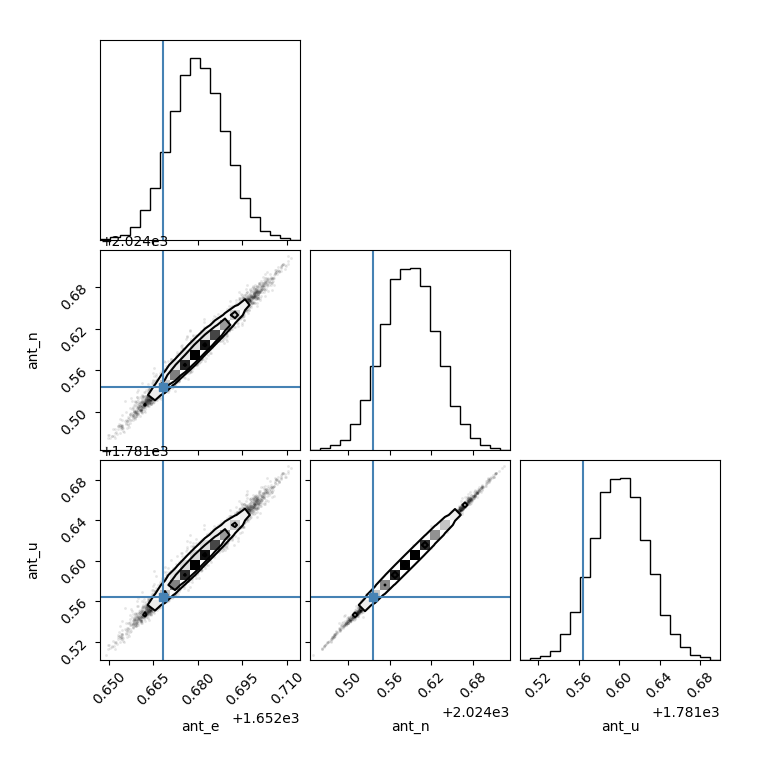

In [ ]:
#trying emcee
import emcee

def log_probability(theta):
    """theta = [ant_e, ant_n, ant_u]"""
    # Prior
    log_prior = -0.5 * np.sum(((theta - ant_pos_prior) / 30.0)**2)
    
    # Likelihood
    log_like = pos_slvr.total_loss(theta) - log_prior  # total_loss includes prior, so subtract it
    
    return log_prior + log_like

# Initialize walkers near MAP
ndim = 3
nwalkers = 32
pos = result.x + 1e-2 * np.random.randn(nwalkers, ndim)

# Run MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)
sampler.run_mcmc(pos, 5000, progress=True)

# Get samples
samples = sampler.get_chain(discard=1000, thin=15, flat=True)

# Corner plot!
import corner
fig = corner.corner(samples, labels=['ant_e', 'ant_n', 'ant_u'], truths=result.x)

# plt.savefig('corner_emcee.png')

In [ ]:
# 1. Posterior mean (Bayes-optimal under squared loss)
posterior_mean = np.mean(samples, axis=0)
print("Posterior Mean:")
print(f"  E: {posterior_mean[0]:.2f} m")
print(f"  N: {posterior_mean[1]:.2f} m")
print(f"  U: {posterior_mean[2]:.2f} m")

# 2. Posterior median (robust to outliers)
posterior_median = np.median(samples, axis=0)
print("\nPosterior Median:")
print(f"  E: {posterior_median[0]:.2f} m")
print(f"  N: {posterior_median[1]:.2f} m")
print(f"  U: {posterior_median[2]:.2f} m")

# 3. MAP estimate (what you got from scipy)
print("\nMAP (from optimization):")
print(f"  E: {result.x[0]:.2f} m")
print(f"  N: {result.x[1]:.2f} m")
print(f"  U: {result.x[2]:.2f} m")

# 4. Uncertainties (standard deviation)
posterior_std = np.std(samples, axis=0)
print("\nPosterior Standard Deviation:")
print(f"  E: ±{posterior_std[0]:.2f} m")
print(f"  N: ±{posterior_std[1]:.2f} m")
print(f"  U: ±{posterior_std[2]:.2f} m")

# 5. Credible intervals (95%)
ci_lower = np.percentile(samples, 2.5, axis=0)
ci_upper = np.percentile(samples, 97.5, axis=0)

print("\n95% Credible Intervals:")
for i, label in enumerate(['E', 'N', 'U']):
    print(f"  {label}: [{ci_lower[i]:.2f}, {ci_upper[i]:.2f}] m")

# 6. Final answer with uncertainty
print("\n" + "="*50)
print("FINAL RESULT:")
print("="*50)
final_position = posterior_mean  # or posterior_median, both are reasonable
print(f"Antenna Position:")
print(f"  East:  {final_position[0]:.2f} ± {posterior_std[0]:.2f} m")
print(f"  North: {final_position[1]:.2f} ± {posterior_std[1]:.2f} m")
print(f"  Up:    {final_position[2]:.2f} ± {posterior_std[2]:.2f} m")
print(f"\n95% Credible Region:")
print(f"  E: [{ci_lower[0]:.2f}, {ci_upper[0]:.2f}] m")
print(f"  N: [{ci_lower[1]:.2f}, {ci_upper[1]:.2f}] m")
print(f"  U: [{ci_lower[2]:.2f}, {ci_upper[2]:.2f}] m")


Posterior Mean:
  E: 1652.68 m
  N: 2024.59 m
  U: 1781.60 m

Posterior Median:
  E: 1652.68 m
  N: 2024.59 m
  U: 1781.60 m

MAP (from optimization):
  E: 1652.67 m
  N: 2024.54 m
  U: 1781.56 m

Posterior Standard Deviation:
  E: ±0.01 m
  N: ±0.04 m
  U: ±0.03 m

95% Credible Intervals:
  E: [1652.66, 1652.70] m
  N: [2024.51, 2024.67] m
  U: [1781.55, 1781.66] m

FINAL RESULT:
Antenna Position:
  East:  1652.68 ± 0.01 m
  North: 2024.59 ± 0.04 m
  Up:    1781.60 ± 0.03 m

95% Credible Region:
  E: [1652.66, 1652.70] m
  N: [2024.51, 2024.67] m
  U: [1781.55, 1781.66] m


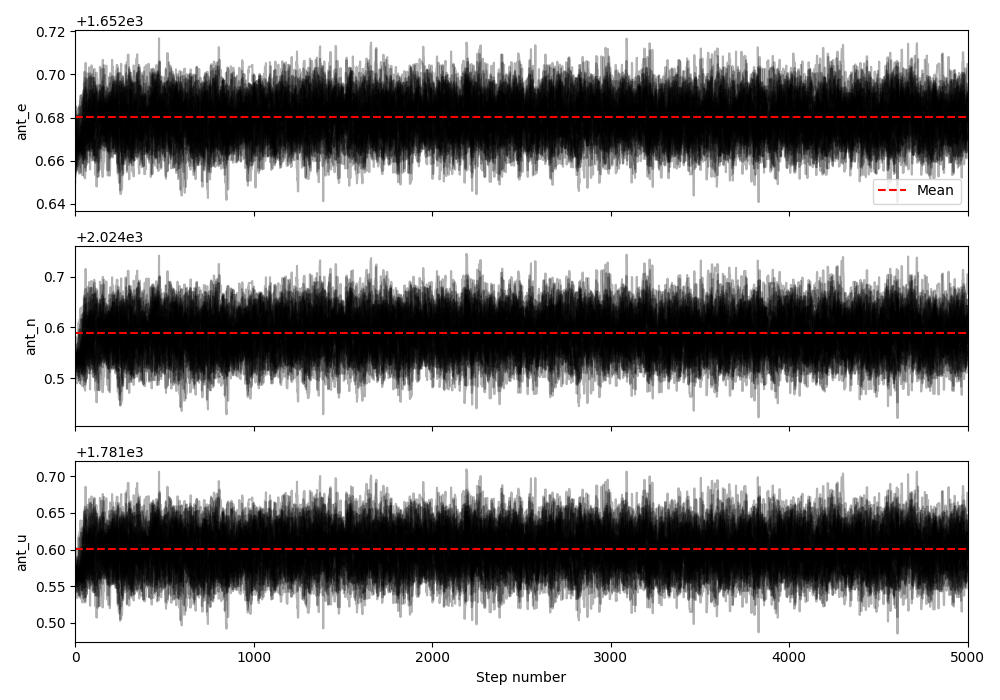

Mean acceptance fraction: 0.652
✓ Good if between 0.2-0.5

Autocorrelation time: [41.37396857 41.84805007 41.96672123]
Effective sample size: 3813
✓ Good if > 1000

=== LOG PROBABILITY CHECK ===
Prior log prob: -8989.1
MAP log prob: -2898.8
Posterior samples log prob:
  Mean: -2900.2
  Median: -2900.0
  Min: -2909.2
  Max: -2898.1

✓ Samples should have log prob similar to MAP
  Difference: -1.5
  (Should be within ~10-50 of each other)

=== POSTERIOR vs MAP ===
Distance: 0.065 m
✓ Should be small (< few meters)

=== SAMPLE RANGES ===
E: [1652.6, 1652.7]
  Prior: 1646.0, MAP: 1652.7
N: [2024.4, 2024.7]
  Prior: 2022.0, MAP: 2024.5
U: [1781.5, 1781.7]
  Prior: 1782.0, MAP: 1781.6

SANITY CHECK:
Samples have similar log prob to MAP? True


In [ ]:
# 1. TRACE PLOTS - Visual check for convergence
samples_full = sampler.get_chain()
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
labels = ['ant_e', 'ant_n', 'ant_u']

for i in range(3):
    ax = axes[i]
    ax.plot(samples_full[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_full))
    ax.set_ylabel(labels[i])
    ax.axhline(posterior_mean[i], color="r", linestyle="--", label="Mean")
    
axes[-1].set_xlabel("Step number")
axes[0].legend()
plt.tight_layout()
plt.savefig('trace_plots.png')
plt.show()

# 2. ACCEPTANCE FRACTION
print(f"Mean acceptance fraction: {np.mean(sampler.acceptance_fraction):.3f}")
print("✓ Good if between 0.2-0.5")

# 3. AUTOCORRELATION TIME
try:
    tau = sampler.get_autocorr_time()
    print(f"\nAutocorrelation time: {tau}")
    n_effective = nwalkers * 5000 / np.max(tau)
    print(f"Effective sample size: {n_effective:.0f}")
    print(f"✓ Good if > 1000")
except:
    print("⚠ Could not compute autocorrelation - chain might be too short")

# 4. LOG PROBABILITY CHECK - Most important!
# Calculate log prob for random samples from posterior
n_check = 100
random_indices = np.random.choice(len(samples), n_check, replace=False)

log_probs = []
for idx in random_indices:
    theta = samples[idx]
    logp = pos_slvr.total_loss(theta)
    log_probs.append(logp)

log_probs = np.array(log_probs)

print(f"\n=== LOG PROBABILITY CHECK ===")
print(f"Prior log prob: {pos_slvr.total_loss(ant_pos_prior):.1f}")
print(f"MAP log prob: {pos_slvr.total_loss(result.x):.1f}")
print(f"Posterior samples log prob:")
print(f"  Mean: {np.mean(log_probs):.1f}")
print(f"  Median: {np.median(log_probs):.1f}")
print(f"  Min: {np.min(log_probs):.1f}")
print(f"  Max: {np.max(log_probs):.1f}")

# THIS IS THE KEY CHECK:
print(f"\n✓ Samples should have log prob similar to MAP")
print(f"  Difference: {np.mean(log_probs) - pos_slvr.total_loss(result.x):.1f}")
print(f"  (Should be within ~10-50 of each other)")

# 5. Compare posterior mean to MAP
print(f"\n=== POSTERIOR vs MAP ===")
print(f"Distance: {np.linalg.norm(posterior_mean - result.x):.3f} m")
print(f"✓ Should be small (< few meters)")

# 6. Verify samples are in reasonable range
print(f"\n=== SAMPLE RANGES ===")
for i, label in enumerate(['E', 'N', 'U']):
    print(f"{label}: [{samples[:, i].min():.1f}, {samples[:, i].max():.1f}]")
    print(f"  Prior: {ant_pos_prior[i]:.1f}, MAP: {result.x[i]:.1f}")

# If this is approximately True, you're golden:
logp_samples_mean = np.mean(log_probs)
logp_map = pos_slvr.total_loss(result.x)

print(f"\nSANITY CHECK:")
print(f"Samples have similar log prob to MAP? {abs(logp_samples_mean - logp_map) < 100}")

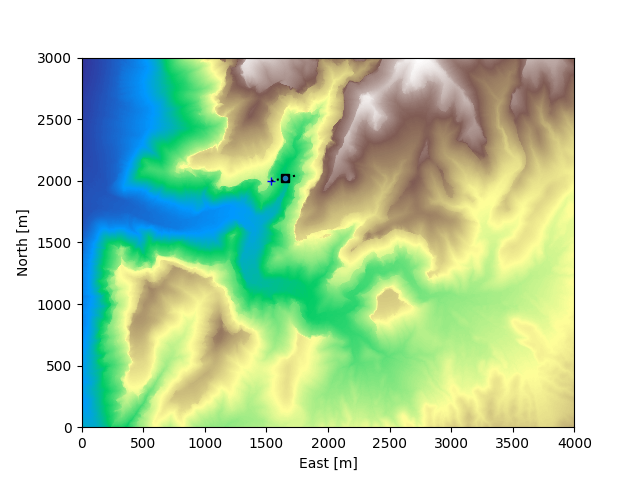

In [44]:
#e,n,u = dem.latlon_to_enu(39.247907, -113.402715)
#u = dem.interp_alt(e, n)
#print(e, n, u)
fig, ax = plt.subplots()
e0, n0, u0 = dem['platform']
rng = 750
plot_img(ax, dem.data, dem.res)
mean_ant_e = posterior_mean[0]
mean_ant_n = posterior_mean[1]
mean_ant_u = posterior_mean[2]
plt.plot([e0], [n0], 's', color='k')
for img in imgs[-1:]:
    e, n, u = img.prms['e'], img.prms['n'], img.prms['u']
    plt.plot([e], [n], '+', color='blue')
    ant_ray = img.get_rays(pixels=np.array(img.meta['ant_px'][::-1]))
    plt.plot([e, e + ant_ray[0] * 220], [n, n + ant_ray[1] * 220], ':', color='k')
    plt.plot(mean_ant_e, mean_ant_n, '.');

In [45]:
theta = np.array([mean_ant_e, mean_ant_n, mean_ant_u])
# theta = ant_pos_prior
pos_slvr.set_mcmc_prms(theta)
logp = pos_slvr.total_loss(theta)
logp


-2898.2910034748816